AIM: 
- explore data to refine questions about data
- search for answers by visual comparisons and transformations


In [1]:
import sys, os
import numpy as np
import pandas as pd
import geopandas as gpd

import re
import datetime
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt
import seaborn as sns
import contextily as cx
import mplleaflet as mpl


pd.set_option('display.max_columns', None)
plt.figure(figsize=(20, 10))
sns.set_style('darkgrid')

<Figure size 2000x1000 with 0 Axes>

In [2]:
# load raw survey data

raw_data = pd.read_excel("../input_survey_data/all-attributes_shophouses.xlsx")#, thousands=',')
raw_data.head(5)

,Q0.1,Q0.2.Ward,Q0.2.District,Q0.3,Q0.4,Q0.5,Q0.6,Q0.7,Pre.Q1,Pre.Q2,P1Q1,P1Q1.specify,P1Q2.1.1,P1Q2.2.1,P1Q2.3.1,P1Q2.4.1,P1Q2.5.1.0,P1Q2.5.1.1,P1Q2.5.1.2,P1Q2.5.1.3,P1Q2.5.1.4,P1Q2.5.1.88,P1Q2.5.1.99,P1Q2.5.1.specify,P1Q2.6.1,P1Q2.7.1.1,P1Q2.7.1.2,P1Q2.7.1.3,P1Q2.7.1.88,P1Q2.7.1.99,P1Q2.7.1.specify,P1Q2.8.1.1,P1Q2.8.1.2,P1Q2.8.1.3,P1Q2.8.1.4,P1Q2.8.1.5,P1Q2.8.1.6,P1Q2.8.1.7,P1Q2.8.1.8,P1Q2.8.1.9,P1Q2.8.1.10,P1Q2.8.1.99,P1Q2.8.1.specify,P1Q2.9.1,P1Q2.10.1.1,P1Q2.10.1.2,P1Q2.10.1.3,P1Q2.10.1.4,P1Q2.10.1.5,P1Q2.10.1.6,P1Q2.10.1.7,P1Q2.10.1.8,P1Q2.10.1.9,P1Q2.10.1.88,P1Q2.10.1.99,P1Q2.10.1.specify,P1Q2.11.1.1,P1Q2.11.1.2,P1Q2.11.1.3,P1Q2.11.1.4,P1Q2.11.1.5,P1Q2.11.1.6,P1Q2.11.1.7,P1Q2.11.1.8,P1Q2.11.1.9,P1Q2.11.1.88,P1Q2.11.1.99,P1Q2.11.1.specify,P1Q3.2.1,P1Q3.3.1,P1Q3.4.1,P1Q3.5.1,P1Q3.6.1,P1Q3.7.1,P1Q3.88.1,P1Q3.88.1.specify,P1Q3.8.1,P1Q3.9.1.man,P1Q3.9.1.days,P1Q3.10.1.1,P1Q3.10.1.2,P1Q3.10.1.3,P1Q3.10.1.4,P1Q3.10.1.5,P1Q3.10.1.6,P1Q3.10.1.88,P1Q3.10.1.99,P1Q3.10.1.specify,P1Q3.11.1,P1Q4.2.1,P1Q4.3.1,P1Q4.4.1,P1Q4.5.1,P1Q4.88.1,P1Q4.88.1.specify,P1Q4.6.1,P1Q5.2.1,P1Q5.3.1,P1Q5.4.1,P1Q5.5.1,P1Q5.88.1,P1Q5.88.1.specify,P1Q5.6.1,P1Q5.7.1,P1Q5.8.1,P1Q5.9.1,P1Q6.2.1.1.relationship,P1Q6.2.1.1.specify,P1Q6.2.1.1.sex,P1Q6.2.1.1.Age,P1Q6.3.1.1.Rank1,P1Q6.3.1.1.Rank2,P1Q6.3.1.1.Rank3,P1Q6.3.1.1.Rank4,P1Q6.3.1.1.Rank5,P1Q6.3.1.1.Rank88,P1Q6.3.1.1.specify,P1Q6.4.1.1,P1Q6.2.1.2.relationship,P1Q6.2.1.2.specify,P1Q6.2.1.2.sex,P1Q6.2.1.2.Age,P1Q6.3.1.2.Rank1,P1Q6.3.1.2.Rank2,P1Q6.3.1.2.Rank3,P1Q6.3.1.2.Rank4,P1Q6.3.1.2.Rank5,P1Q6.3.1.2.Rank88,P1Q6.3.1.2.specify,P1Q6.4.1.2,P1Q6.2.1.3.relationship,P1Q6.2.1.3.specify,P1Q6.2.1.3.sex,P1Q6.2.1.3.Age,P1Q6.3.1.3.Rank1,P1Q6.3.1.3.Rank2,P1Q6.3.1.3.Rank3,P1Q6.3.1.3.Rank4,P1Q6.3.1.3.Rank5,P1Q6.3.1.3.Rank88,P1Q6.3.1.3.specify,P1Q6.4.1.3,P1Q7.2.1.1,P1Q7.2.1.2,P1Q7.2.1.3,P1Q7.2.1.4,P1Q7.2.1.5,P1Q7.2.1.88,P1Q7.2.1.98,P1Q7.2.1.99,P1Q7.2.1.specify,P1Q7.3.1.1,P1Q7.3.1.2,P1Q7.3.1.3,P1Q7.3.1.4,P1Q7.3.1.5,P1Q7.3.1.6,P1Q7.3.1.88,P1Q7.3.1.98,P1Q7.3.1.99,P1Q7.3.1.specify,P1Q2.1.2,P1Q2.2.2,P1Q2.3.2,P1Q2.4.2,P1Q2.5.2.0,P1Q2.5.2.1,P1Q2.5.2.2,P1Q2.5.2.3,P1Q2.5.2.4,P1Q2.5.2.88,P1Q2.5.2.99,P1Q2.5.2.specify,P1Q2.6.2,P1Q2.7.2.1,P1Q2.7.2.2,P1Q2.7.2.3,P1Q2.7.2.88,P1Q2.7.2.99,P1Q2.7.2.specify,P1Q2.8.2.1,P1Q2.8.2.2,P1Q2.8.2.3,P1Q2.8.2.4,P1Q2.8.2.5,P1Q2.8.2.6,P1Q2.8.2.7,P1Q2.8.2.8,P1Q2.8.2.9,P1Q2.8.2.10,P1Q2.8.2.99,P1Q2.8.2.specify,P1Q2.9.2,P1Q2.10.2.1,P1Q2.10.2.2,P1Q2.10.2.3,P1Q2.10.2.4,P1Q2.10.2.5,P1Q2.10.2.6,P1Q2.10.2.7,P1Q2.10.2.8,P1Q2.10.2.9,P1Q2.10.2.88,P1Q2.10.2.99,P1Q2.10.2.specify,P1Q2.11.2.1,P1Q2.11.2.2,P1Q2.11.2.3,P1Q2.11.2.4,P1Q2.11.2.5,P1Q2.11.2.6,P1Q2.11.2.7,P1Q2.11.2.8,P1Q2.11.2.9,P1Q2.11.2.88,P1Q2.11.2.99,P1Q2.11.2.specify,P1Q3.2.2,P1Q3.3.2,P1Q3.4.2,P1Q3.5.2,P1Q3.6.2,P1Q3.7.2,P1Q3.88.2,P1Q3.88.2.specify,P1Q3.8.2,P1Q3.9.2.man,P1Q3.9.2.days,P1Q3.10.2.1,P1Q3.10.2.2,P1Q3.10.2.3,P1Q3.10.2.4,P1Q3.10.2.5,P1Q3.10.2.6,P1Q3.10.2.88,P1Q3.10.2.99,P1Q3.10.2.specify,P1Q3.11.2,P1Q4.2.2,P1Q4.3.2,P1Q4.4.2,P1Q4.5.2,P1Q4.88.2,P1Q4.88.2.specify,P1Q4.6.2,P1Q5.2.2,P1Q5.3.2,P1Q5.4.2,P1Q5.5.2,P1Q5.88.2,P1Q5.88.2.specify,P1Q5.6.2,P1Q5.7.2,P1Q5.8.2,P1Q5.9.2,P1Q6.2.2.1.relationship,P1Q6.2.2.1.specify,P1Q6.2.2.1.sex,P1Q6.2.2.1.Age,P1Q6.3.2.1.Rank1,P1Q6.3.2.1.Rank2,P1Q6.3.2.1.Rank3,P1Q6.3.2.1.Rank4,P1Q6.3.2.1.Rank5,P1Q6.3.2.1.Rank88,P1Q6.3.2.1.specify,P1Q6.4.2.1,P1Q6.2.2.2.relationship,P1Q6.2.2.2.specify,P1Q6.2.2.2.sex,P1Q6.2.2.2.Age,P1Q6.3.2.2.Rank1,P1Q6.3.2.2.Rank2,P1Q6.3.2.2.Rank3,P1Q6.3.2.2.Rank4,P1Q6.3.2.2.Rank5,P1Q6.3.2.2.Rank88,P1Q6.3.2.2.specify,P1Q6.4.2.2,P1Q6.2.2.3.relationship,P1Q6.2.2.3.specify,P1Q6.2.2.3.sex,P1Q6.2.2.3.Age,P1Q6.3.2.3.Rank1,P1Q6.3.2.3.Rank2,P1Q6.3.2.3.Rank3,P1Q6.3.2.3.Rank4,P1Q6.3.2.3.Rank5,P1Q6.3.2.3.Rank88,P1Q6.3.2.3.specify,P1Q6.4.2.3,P1Q7.2.2.1,P1Q7.2.2.2,P1Q7.2.2.3,P1Q7.2.2.4,P1Q7.2.2.5,P1Q7.2.2.88,P1Q7.2.2.98,P1Q7.2.2.99,P1Q7.2.2.specify,P1Q7.3.2.1,P1Q7.3.2.2,P1Q7.3.2.3,P1Q7.3.2.4,P1Q7.3.2.5,P1Q7.3.2.6,P1Q7.3.2.88,P1Q7.3.2.98,P1Q7.3.2.99,P1Q7.3.2.specify,P2Q1.1.implement,P2Q1.1.spend,P2Q1.2.implement,P2Q1.2

#####################

In [372]:
df_aa = df_a
df_aa.shape

(252, 569)

In [373]:
for c in df_aa.columns:
    #print(c, df_aa[c].isna().sum())
   # df_candidates_X.astype(float)[c].fillna((df_candidates_X.astype(float)[c].mean()), inplace=True)
    df_aa = df_aa.astype(float).fillna(df_aa.mean())
df_aa.info()

ValueError: could not convert string to float: '10.833199, 106.7438'

In [85]:
df_aa = df_aa.dropna(axis=1, how='all')
print(df_aa.shape, df_aa.head(2))

df_aa_X = df_aa[df_aa.columns.drop(list(df_aa.filter(regex='^Target')))]  # only explanatory vars

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(df_aa_X) # standarize the variables

#df_candidates_X = np.nan_to_num(df_candidates_X)

(252, 456)    Target_direct_r  Target_direct_s  business_reduction_r   
0             30.0             30.0                  30.0  \
1              0.0             97.0                   0.0   

   business_reduction_s          Q0.1  Q0.2.Ward  Q0.2.District  Q0.4  Q0.7   
0                  30.0  4.020000e+12  17.646552            8.0   1.0   4.0  \
1                  30.0  2.010010e+12  28.000000            8.0   1.0  14.0   

   Pre.Q1  Pre.Q2  P1Q1     P1Q2.1.1  P1Q2.3.1  P1Q2.4.1  contaminations.0   
0     1.0     1.0   5.0  2017.142857      48.0     120.0               0.0  \
1     1.0     1.0   6.0  2017.142857       1.0     110.0               0.0   

   contaminations.1  contaminations.2  contaminations.3  contaminations.4   
0               0.0               0.0               0.0               1.0  \
1               1.0               0.0               0.0               1.0   

   contaminations.88  contaminations.99  P1Q2.6.1  P1Q2.7.1.1  P1Q2.7.1.2   
0                0.0   

In [91]:
## We will start by using only the first 2 leading principal components, and then explore 3 principal components and 4 principal components.
pca = PCA(0.95)  # 95% of the variance should be explained
PC = pca.fit_transform(X)
principalDF = pd.DataFrame(data=PC)#, columns=['pc1','pc2', 'pc3'])
df_pca = pd.concat([principalDF, df_aa[['Target_direct_s']]], axis = 1)
df_pca.head()
#X.columns.tolist()
print(pca.n_components_)

PC_loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
components = df_aa_X.columns.tolist()  # use X before standarized

loadingdf = pd.DataFrame(PC_loadings)#, columns=('PC1','PC2', 'PC3'))
loadingdf["variable"] = components
loadingdf


149


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,variable
0,3.192698e-01,7.620695e-02,2.835987e-02,0.004917,5.959165e-02,-1.317646e-01,-1.475793e-01,-3.151817e-02,1.584433e-01,-7.525744e-02,-0.002339,6.746270e-03,1.695237e-02,1.389055e-01,1.019097e-01,3.564116e-02,-0.038537,-1.913258e-01,8.034696e-02,-1.363773e-02,2.698514e-03,6.983863e-02,1.492477e-01,-1.808752e-01,0.077233,-1.707697e-01,-2.176909e-01,-3.614221e-01,-9.353831e-02,-1.005969e-01,-1.146075e-01,-1.373106e-01,-6.838439e-02,4.460353e-02,-2.369058e-02,-4.825471e-02,-7.019266e-02,5.052416e-02,-9.780211e-02,-7.812757e-02,1.943676e-01,2.315668e-02,1.350167e-02,-2.196563e-02,-3.419985e-02,-0.155743,-2.554150e-02,1.703264e-02,6.365129e-02,1.219200e-02,3.579854e-02,2.003478e-02,-5.733775e-02,-3.353850e-02,-8.006054e-04,3.810271e-02,-4.510482e-02,-5.754541e-02,3.152947e-04,-3.869111e-02,1.089852e-01,3.589308e-03,8.094118e-02,-5.732550e-03,7.856550e-02,8.930793e-02,-4.081886e-02,-4.147193e-02,-8.893968e-02,-7.053292e-03,7.334502e-02,0.043586,5.077210e-02,1.749334e-02,-9.517892e-02,1.496953e-01,-9.375076e-02,-2.869436e-03,1.816664e-02,-1.547476e-01,-9.229129e-02,1.329379e-02,-3.033864e-02,9.196906e-03,-4.190582e-02,1.435966e-02,4.879281e-02,3.244440e-02,-3.400152e-02,6.648193e-03,-0.071368,1.430857e-01,-7.775264e-02,7.771612e-02,-2.785064e-03,5.353742e-02,3.542407e-04,4.832168e-02,1.882222e-02,7.312953e-02,-6.161599e-02,3.344113e-02,9.699329e-03,1.901780e-02,-2.538857e-02,1.471134e-02,4.064008e-02,2.786768e-02,-3.956905e-02,-8.853743e-02,4.138780e-03,2.691175e-02,3.231157e-02,3.206852e-02,5.459845e-02,-4.018026e-02,8.309862e-03,-1.909152e-02,-5.086202e-02,1.990172e-02,7.719298e-03,-1.868358e-02,2.931873e-02,9.351090e-03,1.320997e-02,1.139659e-02,3.743860e-03,-7.606620e-02,3.147143e-02,-3.523155e-02,-5.022630e-02,1.025098e-02,9.459430e-03,5.242309e-02,-6.450051e-03,3.855803e-02,-5.346773e-02,-6.139097e-02,-1.119805e-02,2.337611e-02,-3.233715e-02,-4.371366e-02,-4.920109e-02,-4.485118e-02,-8.893196e-02,3.689429e-02,2.507270e-02,-6.949130e-02,-4.320942e-02,business_reduction_r
1,3.142548e-01,6.961120e-02,1.559897e-02,0.023680,6.758267e-02,-1.912247e-01,-1.399772e-01,1.468140e-02,1.230438e-01,2.349289e-02,-0.029549,4.844533e-02,3.918764e-02,1.661790e-01,5.845355e-02,3.459114e-02,-0.041274,-1.656080e-01,6.987027e-02,2.574783e-02,1.301898e-02,1.323258e-02,2.293984e-01,-1.195219e-01,0.033432,-1.613028e-01,-1.548195e-01,-4.037789e-01,-8.792408e-02,-1.045717e-01,-1.510023e-01,-9.258989e-02,8.827140e-04,7.060691e-02,-9.424007e-02,-1.316002e-01,-8.162432e-02,-2.408376e-03,-7.177778e-02,-4.077503e-02,1.794135e-01,1.518544e-02,-4.826385e-02,3.142999e-02,-8.200382e-02,-0.048797,-7.169246e-02,-4.395861e-02,1.095175e-01,4.994430e-02,3.786963e-02,-5.072204e-02,-3.556521e-02,-2.779863e-03,-5.055337e-02,5.121358e-02,-5.334090e-02,-4.924116e-02,3.573847e-02,4.050024e-02,1.073012e-01,3.135118e-03,1.085850e-01,5.164784e-02,6.514020e-02,1.070831e-01,2.372922e-02,1.370701e-02,-1.101393e-01,4.173691e-02,1.094237e-02,0.018593,1.557361e-02,6.891543e-03,-6.880327e-04,1.527035e-01,-6.076345e-02,2.901814e-03,8.989463e-02,-1.437247e-01,-3.934811e-02,3.107439e-02,6.649592e-02,3.218772e-02,-3.767333e-02,9.245266e-03,2.722172e-02,-3.046253e-02,-2.538135e-02,-2.700954e-02,-0.096278,9.458219e-02,-6.151004e-02,6.285780e-02,2.833936e-02,2.825550e-02,3.871381e-02,-1.893662e-02,-3.458722e-03,8.276802e-02,-4.842152e-02,-3.174755e-02,3.269127e-02,6.322221e-02,2.463201e-03,8.446551e-02,9.208090e-02,2.725038e-02,2.576716e-02,-1.837570e-02,-5.438624e-03,1.503767e-02,5.644183e-02,2.942407e-02

In [92]:
transformed = pca.transform(X)
transformed

array([[ 1.02876242e+00, -5.74379027e-01, -7.46608996e-01, ...,
        -1.01646191e-01,  1.13177300e+00,  6.15743720e-01],
       [ 2.26628533e+00,  3.29902715e+00, -1.90581280e+00, ...,
        -1.80047955e+00, -1.25083705e+00, -8.87965218e-01],
       [ 2.87428765e+00, -4.45124692e-01, -2.12442047e+00, ...,
        -5.09344030e-01,  2.66538723e-03,  7.00651384e-01],
       ...,
       [-1.85848460e+00,  1.71416890e-01,  5.97395294e-01, ...,
        -1.19093023e+00,  1.33155169e-01,  1.10640719e-01],
       [ 2.68368878e-01, -2.20346288e+00, -1.21414674e+00, ...,
        -1.27819227e-01,  8.28462387e-01, -4.79986224e-01],
       [-2.43176799e+00,  1.17506368e-01,  1.57168484e-01, ...,
         1.66817055e+00, -1.54134188e-01, -1.02232853e-01]])

#####################

#### Define target variable, set geometry column
.. and move assumed important variable for indirect cost to beginning, maybe this variable could be a furhter target

In [3]:
df = raw_data

## _r = most recent flood , _s = most serious flood
df.insert(0, "Target_direct_r", df.pop("P1Q5.6.1"))  # target var for direct cost on content loss [VND]
df.insert(1, "Target_direct_s", df.pop("P1Q5.6.2"))


C:\Users\Anna\AppData\Local\Temp\ipykernel_14928\2048570836.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.insert(0, "Target_direct_r", df.pop("P1Q5.6.1"))  # target var for direct cost on content loss [VND]
C:\Users\Anna\AppData\Local\Temp\ipykernel_14928\2048570836.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.insert(1, "Target_direct_s", df.pop("P1Q5.6.2"))


In [4]:
# explanatory var: monthly reduction of business [%] -> probl influences mainly economic damage costs
df.insert(2, "business_reduction_r", df.pop("P1Q5.9.1"))  
df.insert(3, "business_reduction_s", df.pop("P1Q5.9.2"))

## rename dates of flood events
df.rename(columns={"P1Q2.2.1": "flood_time_r", "P1Q2.2.2":"flood_time_s"}, inplace=True)


df.tail(2)



C:\Users\Anna\AppData\Local\Temp\ipykernel_14928\3785906589.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.insert(2, "business_reduction_r", df.pop("P1Q5.9.1"))
C:\Users\Anna\AppData\Local\Temp\ipykernel_14928\3785906589.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.insert(3, "business_reduction_s", df.pop("P1Q5.9.2"))


,Target_direct_r,Target_direct_s,business_reduction_r,business_reduction_s,Q0.1,Q0.2.Ward,Q0.2.District,Q0.3,Q0.4,Q0.5,Q0.6,Q0.7,Pre.Q1,Pre.Q2,P1Q1,P1Q1.specify,P1Q2.1.1,flood_time_r,P1Q2.3.1,P1Q2.4.1,P1Q2.5.1.0,P1Q2.5.1.1,P1Q2.5.1.2,P1Q2.5.1.3,P1Q2.5.1.4,P1Q2.5.1.88,P1Q2.5.1.99,P1Q2.5.1.specify,P1Q2.6.1,P1Q2.7.1.1,P1Q2.7.1.2,P1Q2.7.1.3,P1Q2.7.1.88,P1Q2.7.1.99,P1Q2.7.1.specify,P1Q2.8.1.1,P1Q2.8.1.2,P1Q2.8.1.3,P1Q2.8.1.4,P1Q2.8.1.5,P1Q2.8.1.6,P1Q2.8.1.7,P1Q2.8.1.8,P1Q2.8.1.9,P1Q2.8.1.10,P1Q2.8.1.99,P1Q2.8.1.specify,P1Q2.9.1,P1Q2.10.1.1,P1Q2.10.1.2,P1Q2.10.1.3,P1Q2.10.1.4,P1Q2.10.1.5,P1Q2.10.1.6,P1Q2.10.1.7,P1Q2.10.1.8,P1Q2.10.1.9,P1Q2.10.1.88,P1Q2.10.1.99,P1Q2.10.1.specify,P1Q2.11.1.1,P1Q2.11.1.2,P1Q2.11.1.3,P1Q2.11.1.4,P1Q2.11.1.5,P1Q2.11.1.6,P1Q2.11.1.7,P1Q2.11.1.8,P1Q2.11.1.9,P1Q2.11.1.88,P1Q2.11.1.99,P1Q2.11.1.specify,P1Q3.2.1,P1Q3.3.1,P1Q3.4.1,P1Q3.5.1,P1Q3.6.1,P1Q3.7.1,P1Q3.88.1,P1Q3.88.1.specify,P1Q3.8.1,P1Q3.9.1.man,P1Q3.9.1.days,P1Q3.10.1.1,P1Q3.10.1.2,P1Q3.10.1.3,P1Q3.10.1.4,P1Q3.10.1.5,P1Q3.10.1.6,P1Q3.10.1.88,P1Q3.10.1.99,P1Q3.10.1.specify,P1Q3.11.1,P1Q4.2.1,P1Q4.3.1,P1Q4.4.1,P1Q4.5.1,P1Q4.88.1,P1Q4.88.1.specify,P1Q4.6.1,P1Q5.2.1,P1Q5.3.1,P1Q5.4.1,P1Q5.5.1,P1Q5.88.1,P1Q5.88.1.specify,P1Q5.7.1,P1Q5.8.1,P1Q6.2.1.1.relationship,P1Q6.2.1.1.specify,P1Q6.2.1.1.sex,P1Q6.2.1.1.Age,P1Q6.3.1.1.Rank1,P1Q6.3.1.1.Rank2,P1Q6.3.1.1.Rank3,P1Q6.3.1.1.Rank4,P1Q6.3.1.1.Rank5,P1Q6.3.1.1.Rank88,P1Q6.3.1.1.specify,P1Q6.4.1.1,P1Q6.2.1.2.relationship,P1Q6.2.1.2.specify,P1Q6.2.1.2.sex,P1Q6.2.1.2.Age,P1Q6.3.1.2.Rank1,P1Q6.3.1.2.Rank2,P1Q6.3.1.2.Rank3,P1Q6.3.1.2.Rank4,P1Q6.3.1.2.Rank5,P1Q6.3.1.2.Rank88,P1Q6.3.1.2.specify,P1Q6.4.1.2,P1Q6.2.1.3.relationship,P1Q6.2.1.3.specify,P1Q6.2.1.3.sex,P1Q6.2.1.3.Age,P1Q6.3.1.3.Rank1,P1Q6.3.1.3.Rank2,P1Q6.3.1.3.Rank3,P1Q6.3.1.3.Rank4,P1Q6.3.1.3.Rank5,P1Q6.3.1.3.Rank88,P1Q6.3.1.3.specify,P1Q6.4.1.3,P1Q7.2.1.1,P1Q7.2.1.2,P1Q7.2.1.3,P1Q7.2.1.4,P1Q7.2.1.5,P1Q7.2.1.88,P1Q7.2.1.98,P1Q7.2.1.99,P1Q7.2.1.specify,P1Q7.3.1.1,P1Q7.3.1.2,P1Q7.3.1.3,P1Q7.3.1.4,P1Q7.3.1.5,P1Q7.3.1.6,P1Q7.3.1.88,P1Q7.3.1.98,P1Q7.3.1.99,P1Q7.3.1.specify,P1Q2.1.2,flood_time_s,P1Q2.3.2,P1Q2.4.2,P1Q2.5.2.0,P1Q2.5.2.1,P1Q2.5.2.2,P1Q2.5.2.3,P1Q2.5.2.4,P1Q2.5.2.88,P1Q2.5.2.99,P1Q2.5.2.specify,P1Q2.6.2,P1Q2.7.2.1,P1Q2.7.2.2,P1Q2.7.2.3,P1Q2.7.2.88,P1Q2.7.2.99,P1Q2.7.2.specify,P1Q2.8.2.1,P1Q2.8.2.2,P1Q2.8.2.3,P1Q2.8.2.4,P1Q2.8.2.5,P1Q2.8.2.6,P1Q2.8.2.7,P1Q2.8.2.8,P1Q2.8.2.9,P1Q2.8.2.10,P1Q2.8.2.99,P1Q2.8.2.specify,P1Q2.9.2,P1Q2.10.2.1,P1Q2.10.2.2,P1Q2.10.2.3,P1Q2.10.2.4,P1Q2.10.2.5,P1Q2.10.2.6,P1Q2.10.2.7,P1Q2.10.2.8,P1Q2.10.2.9,P1Q2.10.2.88,P1Q2.10.2.99,P1Q2.10.2.specify,P1Q2.11.2.1,P1Q2.11.2.2,P1Q2.11.2.3,P1Q2.11.2.4,P1Q2.11.2.5,P1Q2.11.2.6,P1Q2.11.2.7,P1Q2.11.2.8,P1Q2.11.2.9,P1Q2.11.2.88,P1Q2.11.2.99,P1Q2.11.2.specify,P1Q3.2.2,P1Q3.3.2,P1Q3.4.2,P1Q3.5.2,P1Q3.6.2,P1Q3.7.2,P1Q3.88.2,P1Q3.88.2.specify,P1Q3.8.2,P1Q3.9.2.man,P1Q3.9.2.days,P1Q3.10.2.1,P1Q3.10.2.2,P1Q3.10.2.3,P1Q3.10.2.4,P1Q3.10.2.5,P1Q3.10.2.6,P1Q3.10.2.88,P1Q3.10.2.99,P1Q3.10.2.specify,P1Q3.11.2,P1Q4.2.2,P1Q4.3.2,P1Q4.4.2,P1Q4.5.2,P1Q4.88.2,P1Q4.88.2.specify,P1Q4.6.2,P1Q5.2.2,P1Q5.3.2,P1Q5.4.2,P1Q5.5.2,P1Q5.88.2,P1Q5.88.2.specify,P1Q5.7.2,P1Q5.8.2,P1Q6.2.2.1.relationship,P1Q6.2.2.1.specify,P1Q6.2.2.1.sex,P1Q6.2.2.1.Age,P1Q6.3.2.1.Rank1,P1Q6.3.2.1.Rank2,P1Q6.3.2.1.Rank3,P1Q6.3.2.1.Rank4,P1Q6.3.2.1.Rank5,P1Q6.3.2.1.Rank88,P1Q6.3.2.1.specify,P1Q6.4.2.1,P1Q6.2.2.2.relationship,P1Q6.2.2.2.specify,P1Q6.2.2.2.sex,P1Q6.2.2.2.Age,P1Q6.3.2.2.Rank1,P1Q6.3.2.2.Rank2,P1Q6.3.2.2.Rank3,P1Q6.3.2.2.Rank4,P1Q6.3.2.2.Rank5,P1Q6.3.2.2.Rank88,P1Q6.3.2.2.specify,P1Q6.4.2.2,P1Q6.2.2.3.relationship,P1Q6.2.2.3.specify,P1Q6.2.2.3.sex,P1Q6.2.2.3.Age,P1Q6.3.2.3.Rank1,P1Q6.3.2.3.Rank2,P1Q6.3.2.3.Rank3,P1Q6.3.2.3.Rank4,P1Q6.3.2.3.Rank5,P1Q6.3.2.3.Rank88,P1Q6.3.2.3.specify,P1Q6.4.2.3,P1Q7.2.2.1,P1Q7.2.2.2,P1Q7.2.2.3,P1Q7.2.2.4,P1Q7.2.2.5,P1Q7.2.2.88,P1Q7.2.2.98,P1Q7.2.2.99,P1Q7.2.2.specify,P1Q7.3.2.1,P1Q7.3.2.2,P1Q7.3.2.3,P1Q7.3.2.4,P1Q7.3.2.5,P1Q7.3.2.6,P1Q7.3.2.88,P1Q7.3.2.98,P1Q7.3.2.99,P1Q7.3.2.specify,P2Q1.1.

## Data cleaning 

##### rename columns

In [21]:
## rename certain columns which could be needed as candidate predictors

col_names = {
                     'P1Q2.3.2':'inundation_duration_h',
                     'P1Q2.4.2':'water_depth_cm',
                     
                     'P1Q2.5.1':'contaminations',
                     'P1Q2.9.2':'warning_time_h',
                     'P1Q2.10.1':'emergency_measures', # bis .9, .88 ,.99 , .specify
                     'P1Q2.11.1':'overall_problem_house',
                     'P1Q3.2.1':'damage_level_floor',
                     'P1Q3.3.1':'damage_level_walls',
                     'P1Q3.4.1':'damage_level_foundation',
                     'P1Q3.5.1':'damage_level_doors',
                     'P1Q3.6.1':'damage_level_roof',
                     'P1Q3.7.1':'damage_level_basement',
                     'P1Q3.88.1':'damage_level_other',
                     'P1Q3.88.1.specify':'damage_level_specify',
                     'P1Q3.8.1':'repair_costs_building_VND_r',
                     'P1Q3.8.2':'repair_costs_building_VND_s',
                     'P1Q3.11.1':'repair_costs_building_complete_r',
                     'P1Q3.11.2':'repair_costs_building_complete_s',
                     'P1Q4.6.1':'repair_costs_damaged_contents_r',
                     'P1Q4.6.2':'repair_costs_damaged_contents_s',

                     'P1Q5.1.1':'shp_flood_event',  # = recent or Q5.1.2?=most serious
                     'P1Q5.2.2':'shp_damage_level_furniture',
                     'P1Q5.3.2':'shp_damage_level_electronics',
                     'P1Q5.4.2':'shp_damage_level_business',
                     'P1Q5.5.2':'shp_damage_level_products',
                     'P1Q5.88.2':'shp_damage_level_others',
                    # 'P1Q5.6.2':'shp_total_direct_loss_content',  ## TARGET 1 
                     'P1Q5.7.2':'shp_closed_d',
                     'P1Q5.8.2':'shp_duration_back2normal',
  
                     'P2Q1.1.implement':'protect_valuables_impl',
                     'P2Q1.1.spend':'protect_valuables_spnd',
                     'P2Q1.2.implement':'water_barries_impl',
                     'P2Q1.2.spend':'water_barries_spnd',
                     'P2Q1.3.implement':'pumping_equipment_impl',
                     'P2Q1.3.spend':'pumping_equipment_spnd',
                     'P2Q1.4.implement':'elevation_building_impl',
                     'P2Q1.4.spend':'elevation_building_spnd',
                     'P2Q1.5.implement':'resistant_material_building_impl',
                     'P2Q1.5.spend':'resistant_material_building_spnd',
                     'P2Q1.6.implement':'electricity_higher_impl',
                     'P2Q1.6.spend':'electricity_higher_spnd',
                     'P2Q1.7.implement':'flood_protections_impl',
                     'P2Q1.7.spend':'flood_protections_spnd',
                     'P2Q2.1.1':'elevation_building_year',
                     'P2Q2.2':'elevation_building_height_cm',
                     'P2Q2.3':'elevation_building_elements',
                     'P2Q2.4':'elevation_building_material_costs',
                     'P2Q3.1.1':'insurance_building',
                     'P2Q3.2.1':'insurance_business',
                     
                     'P3Q1.1.1':'city_protection',
                     'P3Q1.2.1':'more_future_affected',
                     'P3Q1.3.1':'government_warnings',
                     'P3Q1.4.1':'government_careing',

                     'P4Q1.10':'household_income_aviable_monthly_mVND',
                     'P4Q1.1':'household_inhabitants_number',
                     'P4Q1.8':'household_education',
                     'P4Q2.1':'building_movingin',
                     'P4Q2.2':'building_year', 
                     'P4Q2.3':'building_floorsize_sqm',
                     'P4Q3.1':'building_foundation', 
                     'P4Q3.2':'building_floor',
                     'P4Q3.3':'building_wall',
                     'P4Q3.4':'building_roof',
                     'P4Q3.5':'building_doors',
                     'P4Q3.6':'building_elevation_rel2surrounding', 
                     'P4Q4.3.1':'building_renovation_elements_r',
                     'P4Q4.3.2':'building_renovation_elements_s',
                     'P4Q4.4.1':'building_renovation_reasons_r',
                     'P4Q4.4.2':'building_renovation_reasons_s',
                     'P4Q4.5.1':'building_renovation_cost_mVND_r',
                     'P4Q4.5.2':'building_renovation_cost_mVND_s',

                     'P5Q1.10':'shp_benefits_last5years',
                     'P5Q1.11':'shp_risk_behaviour',
                     'P5Q1.12':'shp_monetary_resources_prenvention',
                     'P5Q1.1':'shp_position',
                     'P5Q1.2':'shp_established',
                     'P5Q1.3':'shp_sector', 
                     'P5Q1.4':'shp_employees',
                     'P5Q1.5':'shp_avgmonthly_sale_mVND',
                     'P5Q1.6.1':'shp_finance_investments',
                     'P5Q1.7':'shp_capital_mVND',
                     'P5Q1.9':'shp_suppliers_location',
}
# P1Q7.1.1 and .2 = from whom recieved help


for k, v in col_names.items():
    df.rename(columns ={ i: i.replace(k, v) for i in  df.columns }, inplace=True )


In [22]:
#.filter(regex="P5Q1")#.unique()
#raw_data.filter(regex="P4Q3.3").head(12)#astype("Int64").sort_values("P4Q3.2.Rank3")
#raw_data["P4Q3.2.Rank5"].unique()
#df["shp_risk_behaviour"]#.unique()



#### fixing numeric cols


In [42]:
## fix numeric variables containing floats

df_only_numeric_vars = df#.copy(deep=True)

pattern_float_cols = re.compile("^Target*|_spnd$|elevation_building_material_costs|building_floorsize_sqm|shp_capital_mVND$")
df_floats = df_only_numeric_vars.filter(regex=pattern_float_cols).replace(' ', None) 
df_floats = df_floats.filter(regex=pattern).replace(r'^,', '0.', regex=True) # convert e.g ,5 -> 0,5
df_floats = df_floats.filter(regex=pattern).replace(',', '.', regex=True).astype(float) # convert e.g ,5 -> 0,5

for c in df_floats.columns:
    df_only_numeric_vars[c] = df_floats[c].astype(float)
    #df_only_numeric_vars.astype({c: float})

df_only_numeric_vars.elevation_building_material_costs.info();

<class 'pandas.core.series.Series'>
RangeIndex: 252 entries, 0 to 251
Series name: elevation_building_material_costs
Non-Null Count  Dtype  
--------------  -----  
217 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB


In [43]:
#df.pumping_equipment_spnd[df.pumping_equipment_spnd <270000].value_counts().sort_values(ascending=False)
# df.pumping_equipment_spnd[df.pumping_equipment_spnd <270000].unique()


In [44]:
## convert floats such as "2.6", ".55" from mVND to VND in columns for precaution costs (ending with "*.spend$")

print(df_only_numeric_vars.pumping_equipment_spnd[df_only_numeric_vars.pumping_equipment_spnd <2.7].value_counts().sort_values(ascending=False))

for c in df_only_numeric_vars.filter(regex="_spnd$").columns:  # exclude floats
    #print(c)
    #print(df_only_numeric_vars[c].value_counts())
    df_only_numeric_vars[c] = np.where(df_only_numeric_vars[c] % 1 != 0, df_only_numeric_vars[c] * 100000, df_only_numeric_vars[c])
    #df_only_numeric_vars.loc[df_only_numeric_vars[c] % 1 != 0, c] = df_only_numeric_vars[c] * 100000  # alternative
print(df_only_numeric_vars.pumping_equipment_spnd[df_only_numeric_vars.pumping_equipment_spnd > 250000].value_counts().sort_values(ascending=False))

 

pumping_equipment_spnd
0.0    155
2.0     13
1.0      6
Name: count, dtype: int64
pumping_equipment_spnd
2.600000e+05    2
4.500000e+05    1
3.500000e+05    1
3.600000e+05    1
4.900000e+15    1
2.700000e+05    1
7.500000e+05    1
5.500000e+19    1
Name: count, dtype: int64


In [45]:
# print(df.pumping_equipment_spnd[df.pumping_equipment_spnd >25000].unique())
# t = df_only_numeric_vars.pumping_equipment_spnd[df_only_numeric_vars.pumping_equipment_spnd >25000].unique()
# for i in t:
#     print(f"{i:8f}")


In [46]:
## fix numeric variables containing integers

#df.inundation_duration_h.head(15)
df_only_numeric_vars  = df_only_numeric_vars.replace(r'^,', '', regex=True)  # fix remaining values beginning with random commas e.g. ,5

for c in df_only_numeric_vars.columns.drop(df_only_numeric_vars.filter(regex=f'{pattern}|^GPS').columns):  # exclude floats
    df_only_numeric_vars[f"{c}"] = df_only_numeric_vars[f"{c}"].astype(str).apply(lambda x: np.where(x.isdigit(), x, np.nan)) # set remaining errors as nan e.g 1,5
   # df_only_numeric_vars[f"{c}"] = df_only_numeric_vars[f"{c}"].loc[:, df_only_numeric_vars.columns != 'GPS'].astype(float).astype(pd.Int64Dtype())
    df_only_numeric_vars[f"{c}"] = df_only_numeric_vars[f"{c}"].astype(float).astype(pd.Int64Dtype())


## TODO fix: adds somehow more rows
#df_only_numeric_vars = pd.concat([df_only_numeric_vars, df.GPS])
#df_only_numeric_vars["GPS"] = df_only_numeric_vars[0]

print(df_only_numeric_vars.info())
#print(df_only_numeric_vars["water_barries_spnd"].info())#["pumping_equipment_spnd"]  # pumping_equipment # check how it worked



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Columns: 550 entries, Target_direct_r to Q0.14
dtypes: Int64(549), object(1)
memory usage: 1.2+ MB
None


In [47]:
## set all 99 (i dont know) and 2 (didnt cost anything) to 0

pattern_int_cols = re.compile("repair_costs_building_VND_*|repair_costs_building_complete_*|repair_costs_damaged_contents_*|insurance_b*|Rank|building_renovation_cost_mVND_*|shp_capital_mVND")
# pattern_float_cols = re.compile("^Target*|_spnd$|elevation_building_material_costs|building_floorsize_sqm|shp_capital_mVND$")
# df_floats = df_only_numeric_vars.filter(regex=pattern_float_cols).replace(' ', None) 

#raw_data_99 = raw_data.filter(regex=".spend|P1Q3.8.1", axis=1)
df_only_numeric_vars_99 = df_only_numeric_vars.filter(regex=re.compile(pattern_int_cols.pattern + pattern_float_cols.pattern), axis=1).replace(99, 0) 
#raw_data_99.replace(['Spark','PySpark'],['Apache Spark', 'Apache PySpark'], inplace=True)


for c in df_only_numeric_vars_99.columns:
    df_only_numeric_vars[c] = df_only_numeric_vars_99[c]  

## TODO fix float and int cells with 2 and 1, 88
## poss float cols
## INT P1.3.8 (r+s) # repair_costs_building_VND_* (2,99) = 0
# INT .311.1 +.2 # repair_costs_building_complete_* 99=0
#  INT 4.6.1 + .2 crepair_costs_damaged_contents_* ,set 99 to 0 and ,1=0
# FLOAT 5.6 target 99=0
# FLOAT P2. _spend costs P2.1.x.spend  2,99=0
# FLOAT P2Q2.4 elevation_building_material_costs 1,99=0 , keep 3,95 as FLOAT ,rest INT
# INT P2Q3.1.1 insurance_buildinge , 2+99=0
# INT P2Q3.2.1 insurance_business 2+99=0
# INT P3Q2.3 (r+s) Rank 99,88 = 0
# FLOAT P4Q2.3 building_floorsize_sqm (99=real number)
# 4.5 renov costs (r+s) ",5"-> 0.5 , 99=0
# FLOAT P5Q1.7 shp_capital_mVND, 99=0



     

#### aggregate mulitple choice answers

In [48]:
df_a = df_only_numeric_vars.copy(deep=True)

for c in col_names.values():
    df_agg = df_only_numeric_vars.filter(regex=f'^{c}$|^{c}' + r'.*[^y]$', axis=1)  # exclude col ending with "specifcy"
    df_agg = df_agg.select_dtypes(include=np.number) # agg only numeric cols
    ##  count occurences of yes within multiple choice answers (emergency_measures) and leave singel answers unchanged (e.g water_depth_cm)
    if len(df_agg.columns) >= 2:
        df_a[c] = df_agg.eq(1).sum(axis=1)
    else:
        df_a[c] = df_agg.sum(axis=1)   # TODO selelcts also cols with objects (e.g xx.specfic) and sets them to NAN

    #df_a[c] = df_agg.agg("max", axis="columns")  #  binary values for multile choice answers

    #print(df_a[c].head(1))
    ## TODO make nicer: .{,2}$ = matches also col.names ending with 89, 9y etc.
    #df_agg = df_only_numeric_vars.filter(regex=f'^{c}'+ r'.{,2}$|.*[^88][^99][^y]$', axis=1)  # match columns with specfied names and not containing non-numeric values
    #print(df_agg.columns.sort_values(ascending=False))#[:-1])
    #df_a[c]  =  df_a[df_agg.columns[:]].apply(lambda x: ','.join(x.dropna().astype(str)),  axis=1) # rm old cols and keep new aggregated column

    #if len(df_agg.columns) >= 1:
    #    df_a = df_a.drop(df_agg.columns.sort_values(ascending=False)[:-1], axis=1)


In [59]:
df_a[["repair_costs_damaged_contents_r", "repair_costs_damaged_contents_s"]]#.GPS[-20:]

,repair_costs_damaged_contents_r,repair_costs_damaged_contents_s
0,0,2
1,0,140000000
2,0,34000000
3,0,50000000
4,0,16000000
...,...,...
247,0,2
248,0,300000
249,0,1500000
250,0,4000000


### Select targets and candidate predictors 
- selection of predictors similar to Chinh et al 2016
- add coordinate column and unique key column to candidate predictors

In [50]:
# get coords in readable format for gpd

df["lat"] = np.nan
df["lon"] = np.nan

for coord_pair in range(0,len(df)):
    try:
        df["lon"][coord_pair] = [float(s) for s in df["GPS"][coord_pair].split(",")][0]
        df["lat"][coord_pair] = [float(s) for s in df["GPS"][coord_pair].split(",")][1]
    except:  # if no coordiantes exists
        pass


df = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lat, df.lon)
    )
#df = df.drop(columns=['lat', 'lon', 'GPS'])

df.head(1)

C:\Users\Anna\AppData\Local\Temp\ipykernel_14928\149114085.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["lat"] = np.nan
C:\Users\Anna\AppData\Local\Temp\ipykernel_14928\149114085.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["lon"] = np.nan
C:\Users\Anna\AppData\Local\Temp\ipykernel_14928\149114085.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

,Target_direct_r,Target_direct_s,business_reduction_r,business_reduction_s,Q0.1,Q0.2.Ward,Q0.2.District,Q0.3,Q0.4,Q0.5,Q0.6,Q0.7,Pre.Q1,Pre.Q2,P1Q1,P1Q1.specify,P1Q2.1.1,flood_time_r,P1Q2.3.1,P1Q2.4.1,contaminations.0,contaminations.1,contaminations.2,contaminations.3,contaminations.4,contaminations.88,contaminations.99,contaminations.specify,P1Q2.6.1,P1Q2.7.1.1,P1Q2.7.1.2,P1Q2.7.1.3,P1Q2.7.1.88,P1Q2.7.1.99,P1Q2.7.1.specify,P1Q2.8.1.1,P1Q2.8.1.2,P1Q2.8.1.3,P1Q2.8.1.4,P1Q2.8.1.5,P1Q2.8.1.6,P1Q2.8.1.7,P1Q2.8.1.8,P1Q2.8.1.9,P1Q2.8.1.10,P1Q2.8.1.99,P1Q2.8.1.specify,P1Q2.9.1,emergency_measures.1,emergency_measures.2,emergency_measures.3,emergency_measures.4,emergency_measures.5,emergency_measures.6,emergency_measures.7,emergency_measures.8,emergency_measures.9,emergency_measures.88,emergency_measures.99,emergency_measures.specify,overall_problem_house.1,overall_problem_house.2,overall_problem_house.3,overall_problem_house.4,overall_problem_house.5,overall_problem_house.6,overall_problem_house.7,overall_problem_house.8,overall_problem_house.9,overall_problem_house.88,overall_problem_house.99,overall_problem_house.specify,damage_level_floor,damage_level_walls,damage_level_foundation,damage_level_doors,damage_level_roof,damage_level_basement,damage_level_other,damage_level_other.specify,repair_costs_building_VND,P1Q3.9.1.man,P1Q3.9.1.days,P1Q3.10.1.1,P1Q3.10.1.2,P1Q3.10.1.3,P1Q3.10.1.4,P1Q3.10.1.5,P1Q3.10.1.6,P1Q3.10.1.88,P1Q3.10.1.99,P1Q3.10.1.specify,repair_costs_building_complete,P1Q4.2.1,P1Q4.3.1,P1Q4.4.1,P1Q4.5.1,P1Q4.88.1,P1Q4.88.1.specify,repair_costs_damaged_contents_r,P1Q5.2.1,P1Q5.3.1,P1Q5.4.1,P1Q5.5.1,P1Q5.88.1,P1Q5.88.1.specify,P1Q5.7.1,P1Q5.8.1,P1Q6.2.1.1.relationship,P1Q6.2.1.1.specify,P1Q6.2.1.1.sex,P1Q6.2.1.1.Age,P1Q6.3.1.1.Rank1,P1Q6.3.1.1.Rank2,P1Q6.3.1.1.Rank3,P1Q6.3.1.1.Rank4,P1Q6.3.1.1.Rank5,P1Q6.3.1.1.Rank88,P1Q6.3.1.1.specify,P1Q6.4.1.1,P1Q6.2.1.2.relationship,P1Q6.2.1.2.specify,P1Q6.2.1.2.sex,P1Q6.2.1.2.Age,P1Q6.3.1.2.Rank1,P1Q6.3.1.2.Rank2,P1Q6.3.1.2.Rank3,P1Q6.3.1.2.Rank4,P1Q6.3.1.2.Rank5,P1Q6.3.1.2.Rank88,P1Q6.3.1.2.specify,P1Q6.4.1.2,P1Q6.2.1.3.relationship,P1Q6.2.1.3.specify,P1Q6.2.1.3.sex,P1Q6.2.1.3.Age,P1Q6.3.1.3.Rank1,P1Q6.3.1.3.Rank2,P1Q6.3.1.3.Rank3,P1Q6.3.1.3.Rank4,P1Q6.3.1.3.Rank5,P1Q6.3.1.3.Rank88,P1Q6.3.1.3.specify,P1Q6.4.1.3,P1Q7.2.1.1,P1Q7.2.1.2,P1Q7.2.1.3,P1Q7.2.1.4,P1Q7.2.1.5,P1Q7.2.1.88,P1Q7.2.1.98,P1Q7.2.1.99,P1Q7.2.1.specify,P1Q7.3.1.1,P1Q7.3.1.2,P1Q7.3.1.3,P1Q7.3.1.4,P1Q7.3.1.5,P1Q7.3.1.6,P1Q7.3.1.88,P1Q7.3.1.98,P1Q7.3.1.99,P1Q7.3.1.specify,P1Q2.1.2,flood_time_s,inundation_duration_h,water_depth_cm,P1Q2.5.2.0,P1Q2.5.2.1,P1Q2.5.2.2,P1Q2.5.2.3,P1Q2.5.2.4,P1Q2.5.2.88,P1Q2.5.2.99,P1Q2.5.2.specify,P1Q2.6.2,P1Q2.7.2.1,P1Q2.7.2.2,P1Q2.7.2.3,P1Q2.7.2.88,P1Q2.7.2.99,P1Q2.7.2.specify,P1Q2.8.2.1,P1Q2.8.2.2,P1Q2.8.2.3,P1Q2.8.2.4,P1Q2.8.2.5,P1Q2.8.2.6,P1Q2.8.2.7,P1Q2.8.2.8,P1Q2.8.2.9,P1Q2.8.2.10,P1Q2.8.2.99,P1Q2.8.2.specify,warning_time_h,P1Q2.10.2.1,P1Q2.10.2.2,P1Q2.10.2.3,P1Q2.10.2.4,P1Q2.10.2.5,P1Q2.10.2.6,P1Q2.10.2.7,P1Q2.10.2.8,P1Q2.10.2.9,P1Q2.10.2.88,P1Q2.10.2.99,P1Q2.10.2.specify,P1Q2.11.2.1,P1Q2.11.2.2,P1Q2.11.2.3,P1Q2.11.2.4,P1Q2.11.2.5,P1Q2.11.2.6,P1Q2.11.2.7,P1Q2.11.2.8,P1Q2.11.2.9,P1Q2.11.2.88,P1Q2.11.2.99,P1Q2.11.2.specify,P1Q3.2.2,P1Q3.3.2,P1Q3.4.2,P1Q3.5.2,P1Q3.6.2,P1Q3.7.2,P1Q3.88.2,P1Q3.88.2.specify,repair_costs_building_VND_s,P1Q3.9.2.man,P1Q3.9.2.days,P1Q3.10.2.1,P1Q3.10.2.2,P1Q3.10.2.3,P1Q3.10.2.4,P1Q3.10.2.5,P1Q3.10.2.6,P1Q3.10.2.88,P1Q3.10.2.99,P1Q3.10.2.specify,repair_costs_building_complete_s,P1Q4.2.2,P1Q4.3.2,P1Q4.4.2,P1Q4.5.2,P1Q4.88.2,P1Q4.88.2.specify,repair_costs_damaged_contents_s,shp_damage_level_furniture,shp_damage_level_electronics,shp_damage_level_business,shp_damage_level_products,shp_damage_level_others,shp_damage_level_others.specify,shp_closed_d,shp_duration_back2normal,P1Q6.2.2.1.relationship,P1Q6.2.2.1.specify,P1Q6.2.2.1.sex,P1Q6.2.2.1.Age,P1Q6.3.2.1.Rank1,P1Q6.3.2.1.Rank2,P1Q6.3.2.1.Rank3,P1Q6.3.2.1.Rank4,P1Q6.3.2.1.Rank5,P1Q6.3.2.1.Rank88,P1Q6.3.2.1.specify,P

In [51]:
## select only locations within HCMC  - 2 businesses lay outside HCMC
df = df[df.lon >= 10.6000]


In [52]:
candidate_predictors_predicand = [
    "Target_direct_s", "Target_direct_r", 
    "Q0.1", # key column [Location, Interviewer, Month, Day, Number]
    'shp_closed_d', "shp_duration_back2normal", "business_reduction_s", "business_reduction_r", # indirect costs + 'P1Q5.9.2':'shp_monthly_business_reduced_duringFlood[%]',                     
    "inundation_duration_h", "water_depth_cm", "contaminations", 
    "warning_time_h", "emergency_measures",
    "protect_valuables_impl", "water_barries_impl", "flood_protections_impl", "resistant_material_building_impl", "elevation_building_height_cm", "building_elevation_rel2surrounding",
    "repair_costs_damaged_contents_r", "repair_costs_damaged_contents_s",
    # "building_floorsize_sqm",  # TODO fix not in ddf_a, but in numeric df  
    "building_floor",  # floor type (concrete, soil, ceramic..)
    'shp_damage_level_business','shp_damage_level_products', 'insurance_business',
    'shp_sector', 'shp_employees','shp_avgmonthly_sale_mVND', 'shp_capital_mVND',
    "shp_risk_behaviour", "shp_monetary_resources_prenvention"
]


df_candidates = df_a[candidate_predictors_predicand]
df_candidates.columns


Index(['Target_direct_s', 'Target_direct_r', 'Q0.1', 'shp_closed_d',
       'shp_duration_back2normal', 'business_reduction_s',
       'business_reduction_r', 'inundation_duration_h', 'water_depth_cm',
       'contaminations', 'warning_time_h', 'emergency_measures',
       'protect_valuables_impl', 'water_barries_impl',
       'flood_protections_impl', 'resistant_material_building_impl',
       'elevation_building_height_cm', 'building_elevation_rel2surrounding',
       'repair_costs_damaged_contents_r', 'repair_costs_damaged_contents_s',
       'building_floor', 'shp_damage_level_business',
       'shp_damage_level_products', 'insurance_business', 'shp_sector',
       'shp_employees', 'shp_avgmonthly_sale_mVND', 'shp_capital_mVND',
       'shp_risk_behaviour', 'shp_monetary_resources_prenvention'],
      dtype='object')

In [53]:
## add geometry for better identifaction
#df_candidates #= pd.merge(df_candidates, df.loc[:, ["geometry", "Q0.1", "Target_direct_", "Target_direct_r"]], on=["Q0.1", "Target_direct_r", "Target_direct_s"], how="left")
df_candidates = pd.concat([df_candidates, df[["lat", "lon", "geometry"]]], axis=1, ignore_index=False)

df_candidates = gpd.GeoDataFrame(df_candidates)
df_candidates.tail(1)

,Target_direct_s,Target_direct_r,Q0.1,shp_closed_d,shp_duration_back2normal,business_reduction_s,business_reduction_r,inundation_duration_h,water_depth_cm,contaminations,warning_time_h,emergency_measures,protect_valuables_impl,water_barries_impl,flood_protections_impl,resistant_material_building_impl,elevation_building_height_cm,building_elevation_rel2surrounding,repair_costs_damaged_contents_r,repair_costs_damaged_contents_s,building_floor,shp_damage_level_business,shp_damage_level_products,insurance_business,shp_sector,shp_employees,shp_avgmonthly_sale_mVND,shp_capital_mVND,shp_risk_behaviour,shp_monetary_resources_prenvention,lat,lon,geometry
251,<NA>,<NA>,5030020000000,14,20,100,20,5,20,2,99,8,1,1,5,2,100,0,0,10000000,0,1,1,2,17,1,2,0,3,3,106.626656,10.716209,POINT (106.62666 10.71621)


In [54]:
df_candidates.isna().sum();

In [55]:
## save to disk
df_candidates.to_excel("../input_survey_data/survey_data_candidates_coords.xlsx", index=False)



## TODO possible further candidates which needs to be checked and maybe developed: 
## - Indicator of flood warning information 
## - Lead time period elapsed without using it for emergency measure
## - Precautionary measure indicator
## - Perception of efficiency of private precaution
## - Flood experience indicator
## - Knowledge of flood hazard	- as binary
## - Building quality	(Content value in USD - not in HCMC survey data, only indirect derivable via shp_sector)
## - Socioeconomic status according to Plapp [31]
##      'P1Q5.2.2':'shp_damage_level_furniture', 'P1Q5.3.2':'shp_damage_level_electronics', "shp_damage_level_others"

## Exploratory data analysis


In [60]:
## define set for target and explanatory variables

df_candidates_X = df_candidates[df_candidates.columns.drop(list(df_candidates.filter(regex='^Target|^geometry|^Q0.1$')))]  # only explanatory vars
df_candidates_Y = df_candidates[list(df_candidates.filter(regex='^Target'))]  # only predicted vars
# X = df.loc[ :, df.columns != ['Target_direct', 'Target_indirect'] ]



### Overview: flood events timeline, total costs of damages, flood variables 

- select years of flood events
- compare occurence of floods with total direct costs for damages on business contents 


In [67]:
#floods_years_s = pd.to_datetime(floods_time_rs["P1Q2.2.2"], errors='ignore', format='mixed')
df["flood_time_r"] = df["flood_time_r"].str.split(pat="/", expand=True)[2]  
df["flood_time_s"] = df["flood_time_s"].str.split(pat="/", expand=True)[2] 
df["flood_time_r"] = pd.to_datetime(df["flood_time_r"]).dt.strftime('%Y')
df["flood_time_s"] = pd.to_datetime(df["flood_time_s"]).dt.strftime('%Y')
df

KeyError: 2

In [62]:
# df.Target_direct_r  = df.Target_direct_r.replace(r'^,', '', regex=True)  # fix values beginning with random commas e.g. ,5
# df.Target_direct_r = df.Target_direct_r.astype(str).apply(lambda x: np.where(x.isdigit(), x, np.nan)) # set remaining errorneous values as nan e.g 1,5
# df.Target_direct_r = df.Target_direct_r.astype(float).astype(pd.Int64Dtype())
# df.Target_direct_r

# df.Target_direct_s  = df.Target_direct_s.replace(r'^,', '', regex=True)  # fix values beginning with random commas e.g. ,5
# df.Target_direct_s = df.Target_direct_s.astype(str).apply(lambda x: np.where(x.isdigit(), x, np.nan)) # set remaining errorneous values as nan e.g 1,5
# df.Target_direct_s = df.Target_direct_s.astype(float).astype(pd.Int64Dtype())



Text(0, 0.5, 'count')

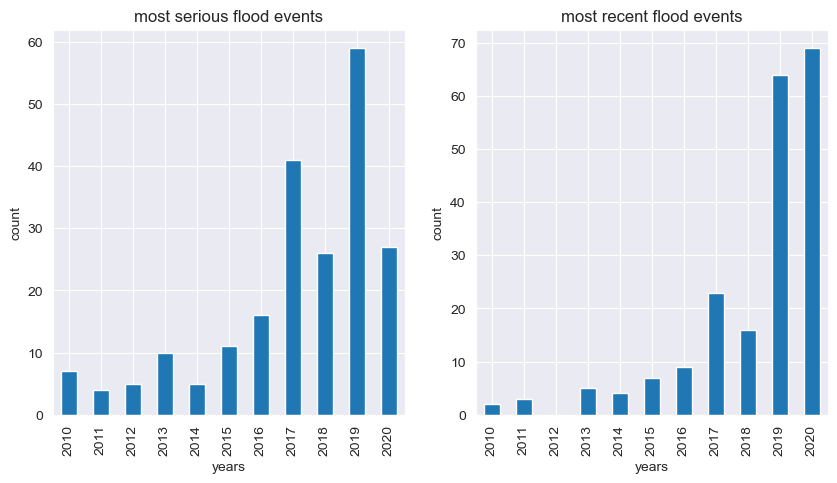

In [63]:
## Timeline: flood events

floods_years_rs = pd.DataFrame({"most_serious": df["flood_time_s"].value_counts(),
       "most_recent": df["flood_time_r"].value_counts()})
floods_years_rs.index.name = "years"


fig, ax = plt.subplots(1,2, figsize=(10,5))

floods_years_rs.most_serious.plot.bar( ax=ax[0], title="most serious flood events")
floods_years_rs.most_recent.plot.bar( ax=ax[1], title="most recent flood events")
ax[0].set_ylabel("count")
ax[1].set_ylabel("count")


In [64]:
df = df.sort_values('flood_time_r')
# rfloods_by_year = pd.DataFrame(df.groupby('flood_time_r')['Target_direct_r'].apply(list).values)
# rfloods_by_year
df.head(10);

In [65]:
## Timeline: Damage costs caused by floods

## TODO check if cost by year are correct - seems erroneous eg. 2019 with many flood events

df = df.sort_values('flood_time_r')
rfloods_by_year = pd.DataFrame(df.groupby('flood_time_r')['Target_direct_r'].apply(list).values).set_index( floods_years_rs.index)#df["flood_time_r"])
df = df.sort_values('flood_time_s')
sfloods_by_year = pd.DataFrame(df.groupby('flood_time_s')['Target_direct_s'].apply(list).values).set_index( floods_years_rs.index)


fig, ax = plt.subplots(1,2, figsize=(10,5))
sfloods_by_year[0].apply(sum).astype("Int64").plot.bar( title="total direct loss to business content \nfor most serious flood events", ax=ax[0])
rfloods_by_year[0].apply(sum).astype("Int64").plot.bar( title="total direct loss to business content \nfor most recent flood events", ax=ax[1])
ax[0].set_ylabel("mVND")
ax[1].set_ylabel("mVND")


ValueError: Length mismatch: Expected 10 rows, received array of length 11

Text(0, 0.5, 'count')

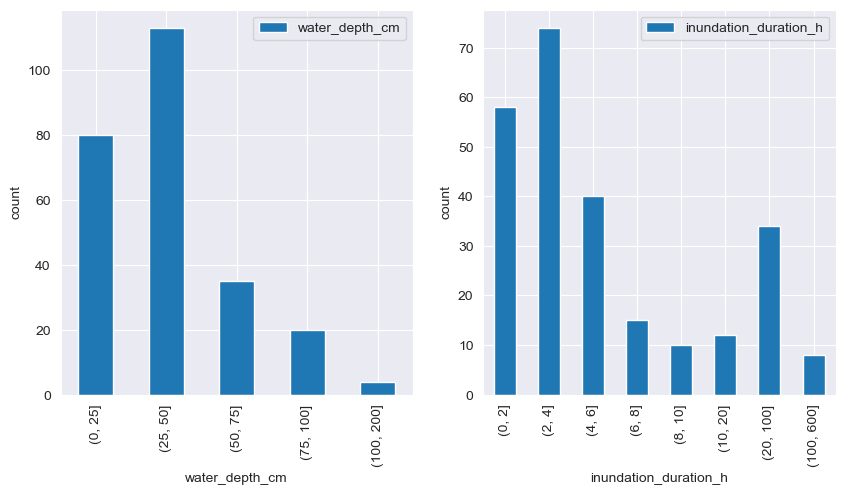

In [66]:
## Timeline: flood variables

## TODO fix xls flood time row=[2,3]

inundation_duration_classes = df_candidates.inundation_duration_h.groupby(pd.cut(df_candidates.inundation_duration_h, [0, 2, 4, 6, 8, 10, 20, 100, 600])).count()
water_depth_classes = df_candidates.water_depth_cm.groupby(pd.cut(df_candidates.water_depth_cm, [0, 25, 50, 75, 100, 200])).count()
inundation_duration_classes = pd.DataFrame(inundation_duration_classes)
water_depth_classes = pd.DataFrame(water_depth_classes)

fig, ax = plt.subplots(1,2, figsize=(10,5))
water_depth_classes.plot.bar( ax=ax[0])
inundation_duration_classes.plot.bar( ax=ax[1])
ax[0].set_ylabel("count")
ax[1].set_ylabel("count")

### TODO: combine both Target columns into one variable
 Test for similaries between predictors for both targets - if similiaries are large than cobine both target columns into one variable


### Map spatial distribution of interviewed businesses 

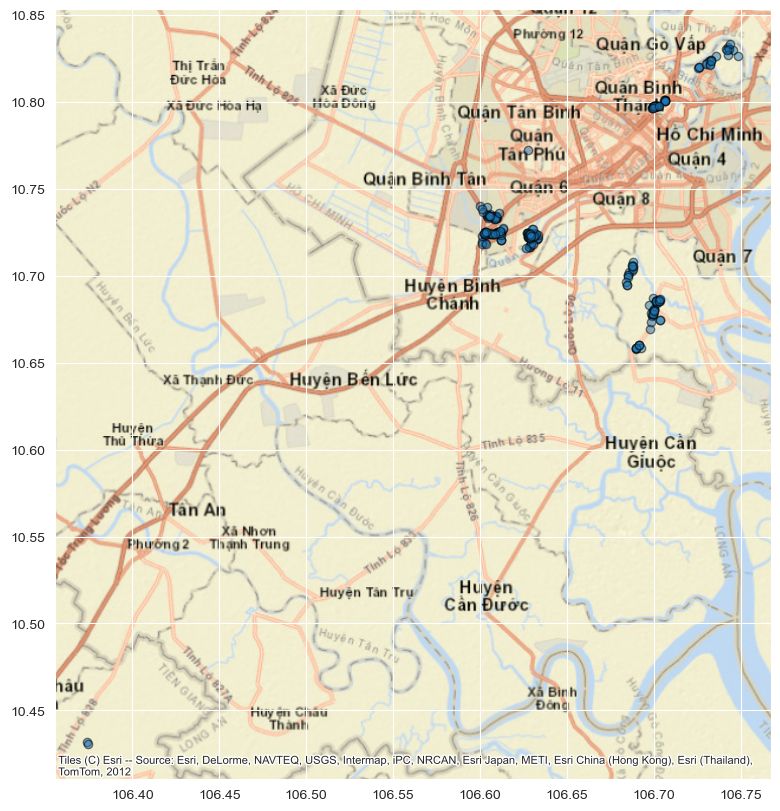

In [20]:
df_coords = df.set_crs("EPSG:4326")
#df_coords_2 = df_coords.to_crs(epsg=3857)

ax = df_coords["geometry"].plot(figsize=(10, 10), alpha=0.5, edgecolor="k") # cx default needs epsg=3857  .to_crs('EPSG:3857').
cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.Esri.WorldStreetMap)#, zoom=15) #,crs='EPSG:4326')#,  , source=cx.providers.TomTom.Basic)  .MapTiler.
                         
#mpl.display(fig=ax.figure, crs=df_coords_2.crs)


## Correlation between variables by Pearson Correlation Coefficient

Identify canidates for the predicand "direct costs for damages of buiness contents" using Pearson Correlation Coefficient

In [21]:
df.filter(regex=r"shp_m").info()


<class 'pandas.core.frame.DataFrame'>
Index: 252 entries, 78 to 238
Data columns (total 1 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   shp_monetary_resources_prenvention  252 non-null    int64
dtypes: int64(1)
memory usage: 3.9 KB


In [22]:
plt.figure(figsize=(8, 8), dpi=80)

sns.heatmap(df_candidates.corr(), cmap="YlOrRd", annot=False, fmt=".2f")


TypeError: float() argument must be a string or a number, not 'Point'

<Figure size 640x640 with 0 Axes>

#### Summarize Pearson Corr Coefs
--> high corr (>0.8) between targets ~ [shp_closed_d, shp_duration_back2normal, shp_emplees, shp_capital_mVND]
--> Low corr coeffs between targets, for 
    emergency_measures, 
    private precautions in VND (eg. water-barriers, water-resistant material) - TODO check for implementations
    building_elevation_rel2surrounding
    warning_time_h
    building_floor
    shp_risk_behaviour
    shp_monetary_resources_prenvention
    --> replace them or combine them with PCA

--> TODO examine shp_damage_level_products low correlation to targets - why?

#### quantify mulitcollinearity


In [ ]:
df_vif = pd.DataFrame()
df_vif["features"] = df_candidates_X.columns
df_candidates_X_filled = df_candidates_X.replace(np.nan, 0)
df_vif["vif_scores"] = [variance_inflation_factor(df_candidates_X_filled.values.astype(float), i)  for i in range(len(df_candidates_X_filled.columns))]
df_vif.sort_values("vif_scores", ascending=False)  
# VIF >5 : high correlation
# VIF 1-10: medium correlation


,features,vif_scores
11,flood_protections_impl,143.576058
12,resistant_material_building_impl,119.823830
0,shp_closed_d,29.405256
1,shp_duration_back2normal,20.531232
9,protect_valuables_impl,17.021937
10,water_barries_impl,13.974013
21,shp_capital_mVND,11.219102
6,contaminations,8.998710
19,shp_employees,7.936704
20,shp_avgmonthly_sale_mVND,7.022346


##### Summarize VIF scores
--> Pearson Corr Coeff shows bivariate correlation between one var ~ to another var
--> VIF shows Correlation between one var ~ group of other vars
--> multicollineary can decrease ML learning (matters only for Regressions). For RF it limits interpretability of used features, i.e. less expressive feature importance, due to redundancy of features  (esp. if only few trees were used) 

--> apply PCA to reduce dimensionality and to solve mulitcollinearity of some predictors (esp. for shp_closed_d, shp_duration_back2normal, shp_capital_mVND, shp_employees,	business_reduction_s, contaminations, shp_avgmonthly_sale_mVND business_reduction_r) or alternatively remove redundant variables , alternativly apply feature selection by e.g. Random Forests "feature importance"


## Variable distribution
- types of businesses = DONE
- water depth and inundation duration = DONE
- educational level
- distribution and amount of obs for business disruptions [monthly reduction %] P1Q5.9
- target 1 : direct costs of losses for business contents [VND] DONE 


In [ ]:
df_candidates.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 26 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Target_direct_s                     247 non-null    Int64
 1   Target_direct_r                     246 non-null    Int64
 2   inundation_duration_h               252 non-null    Int64
 3   water_depth_cm                      252 non-null    Int64
 4   contaminations                      252 non-null    Int64
 5   warning_time_h                      252 non-null    Int64
 6   emergency_measures                  252 non-null    Int64
 7   protect_valuables_impl              252 non-null    Int64
 8   water_barries_impl                  252 non-null    Int64
 9   flood_protections_impl              252 non-null    Int64
 10  resistant_material_building_impl    252 non-null    Int64
 11  elevation_building_height_cm        252 non-null    Int64
 12  building

### Visual analysis of predictor and predicted variable distributions 

#### Summarize visual exploration of variable distribtuions
--> drop var: building_elevation2surrounding
--> mostly exponential distribution, sometimes gaussian distr.

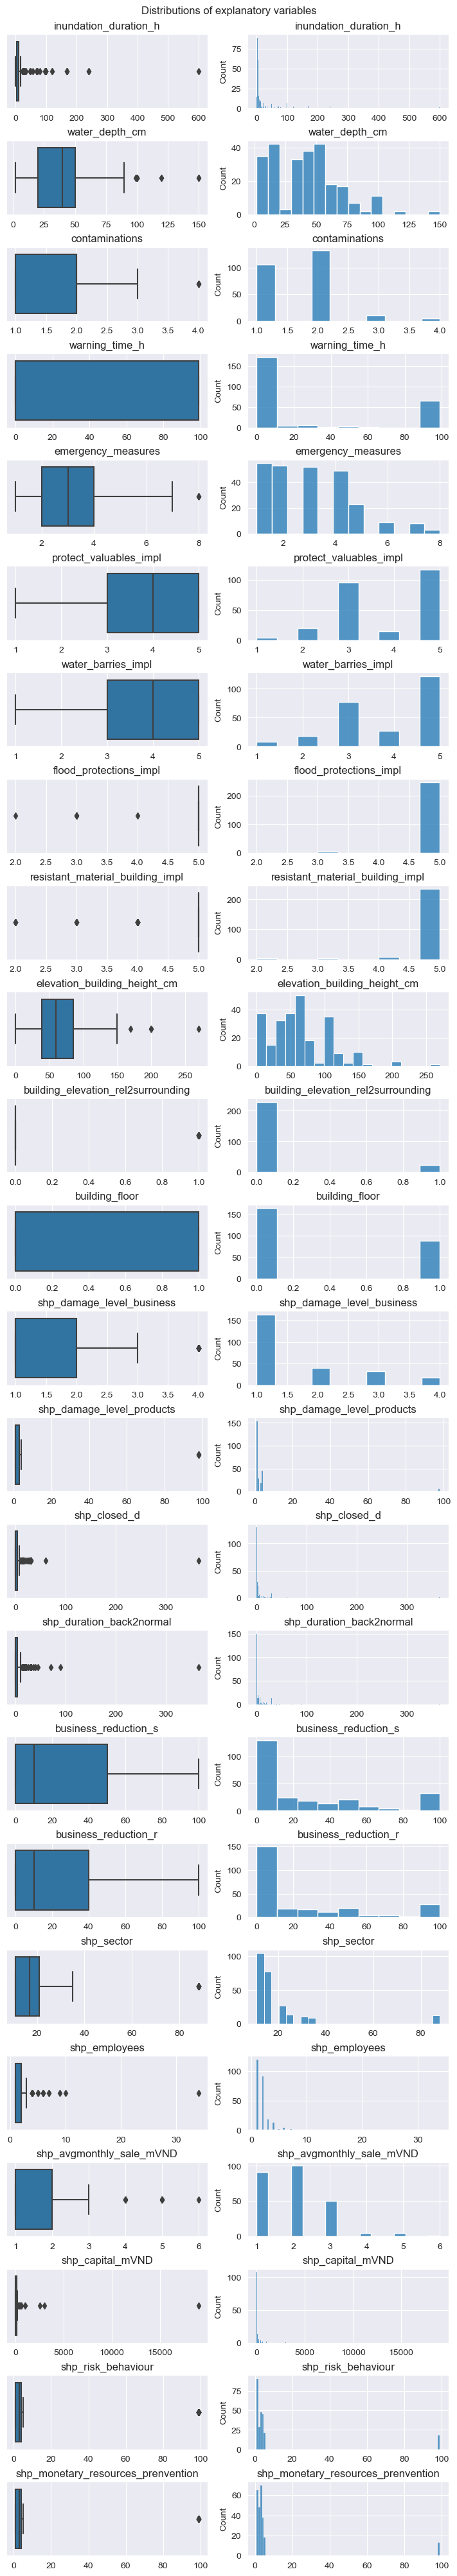

In [ ]:
#plt.figure(figsize=(58, 28))

fig, (ax_hist) = plt.subplots(len(df_candidates_X.columns), 2, sharex=False, figsize=(7, 40), constrained_layout=True)#, gridspec_kw={"height_ratios": (.15, .85)})
#fig.tight_layout()  # alternative for tight_layout() and subplots_adjust(): constrained_layout=True
fig.suptitle('Distributions of explanatory variables')

for i, c in enumerate(df_candidates_X.columns[:]):
    #plt.subplots_adjust(hspace=.2)
    sns.boxplot(x=df_candidates_X[c].astype(float), ax=ax_hist[i, 0]).set(title=f"{c}", xlabel=None)
    sns.histplot(x=df_candidates_X[c].astype(float), stat='count', ax=ax_hist[i, 1]).set(title=f"{c}", xlabel=None) # bins=12, stat="percent"


## TODO : shp_closed, shp_duration_back2normal, shp_damage_level from conitnous -> intervals

# sns.despine(ax=ax_hist)  # arrange boxplots above bar charts
# sns.despine(ax=ax_box, left=True)
# ax_box.set(yticks=[])


#### Target distributions


In [ ]:

#plt.figure(figsize=(10, 28))

fig, (ax_hist) = plt.subplots(len(df_candidates_Y.columns), 2, sharex=False, figsize=(15, 5), constrained_layout=True)#, gridspec_kw={"height_ratios": (.15, .85)})
fig.suptitle('Distributions of predicted variables')
plt.xlim(0, 15)

for i, c in enumerate(df_candidates_Y.columns[:]):
    ax_hist[i,1].set_xlim(0,22)  # limit histoplot
    sns.boxplot(x=df_candidates_Y[c].astype(float), showfliers=True, ax=ax_hist[i, 0]).set(title=f"{c}", xlabel=None)
    sns.histplot( x=df_candidates_Y[c].astype(float), stat='count', ax=ax_hist[i, 1]).set(title=f"{c} - excluded outliers", xlabel=None) #  stat='count', errorbar=("pi", 95), # stat='count', log_scale=True #.set(title=c) # bins=12, stat="percent"
    #sns.countplot(df_candidates_Y[c].astype(float).astype('Int64'), ax=ax_hist[i, 1])  # discrete=False,



NameError: name 'df_candidates_Y' is not defined

#### business types 
grouped by their parent sector


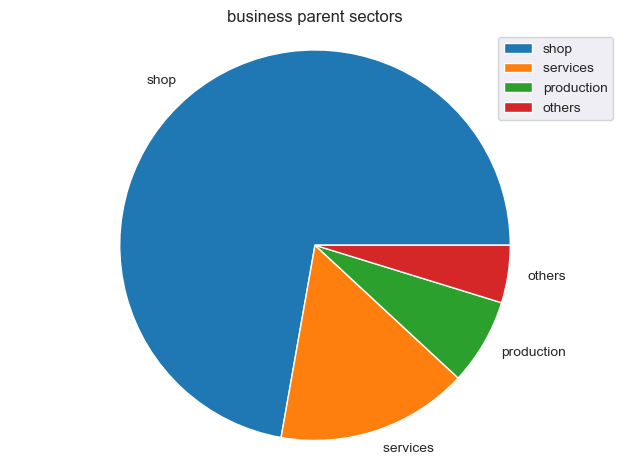

In [ ]:
bins =  np.arange(10, 90, 10)  # business sectors
ind = np.digitize(df['shp_sector'], bins)
 
shp_sectors = df.shp_sector.groupby(ind).value_counts().reset_index(name='sector_freq')
shp_sectors = shp_sectors.groupby("level_0")['sector_freq'].sum().reset_index()
#shp_sectors.shp_sector = shp_sectors.shp_sector.replace([11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 31, 32, 33, 34, 35, 88],["food","fashion", "houseware"])

shp_sectors["sectors"] = shp_sectors.level_0.replace([1, 2, 3, 8],["shop", "services ", "production", "others"])

plt.pie(x="sector_freq", labels="sectors", data=shp_sectors)
plt.legend(shp_sectors.sectors, loc="best")
plt.title("business parent sectors")
plt.axis('equal')
plt.tight_layout()
plt.show()

##### business types of shops

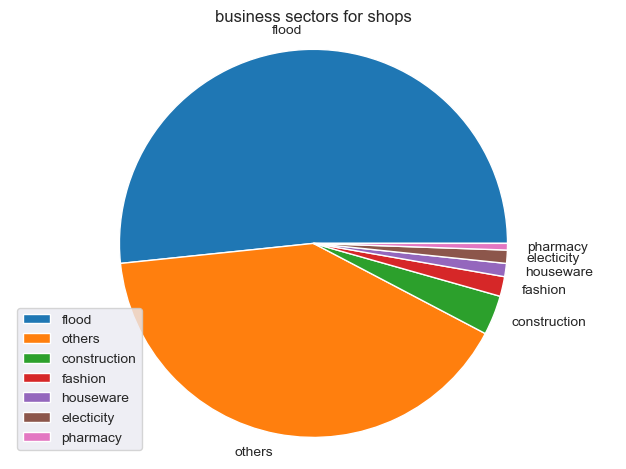

In [ ]:
shop_types = df.shp_sector[df['shp_sector'] < 20]
#shop_types = df[(df['shp_sector'] >= 10) & (df['shp_sector'] < 20)]
shop_types = shop_types.value_counts().reset_index(name='shop_freq')
shop_types["shop_type"] = shop_types.shp_sector.replace([11, 12, 13, 14, 15, 16, 17],["flood", "fashion", "houseware", "construction", "electicity", "pharmacy", "others"])

plt.pie(x="shop_freq", labels="shop_type", data=shop_types)
plt.legend(shop_types.shop_type, loc="best")
plt.title("business sectors for shops")
plt.axis('equal')
plt.tight_layout()
plt.show()


### Statistics of variable distributions
mean, SD, amount of NAN

In [ ]:
df_stats =pd.DataFrame(index=df_candidates.columns)

for c in df_candidates.columns:
    df_stats.loc[c, "min"] = df_candidates[c].min()
    df_stats.loc[c, "max"] = df_candidates[c].max()
    df_stats.loc[c, "mean"] = df_candidates[c].mean().round(2)
    df_stats.loc[c, "median"] = df_candidates[c].median()
    df_stats.loc[c, "sd"] = df_candidates[c].std().round(2)
    df_stats.loc[c, "no_value"] = df_candidates[c].isin([0, 99]).sum() | df_candidates[c].isna().sum()

print(df_stats.head(10))    


                        min     max   mean  median      sd  no_value
Target_direct_s         0.0  6000.0  37.06     0.0  386.11     143.0
Target_direct_r         0.0  6000.0  32.30     0.0  385.20     158.0
inundation_duration_h   0.0   600.0  18.71     4.0   50.84       8.0
water_depth_cm          2.0   150.0  41.28    40.0   26.75       1.0
contaminations          1.0     4.0   1.66     2.0    0.64       0.0
warning_time_h          0.0    99.0  27.75     0.0   43.11     202.0
emergency_measures      1.0     8.0   3.02     3.0    1.67       0.0
protect_valuables_impl  1.0     5.0   3.88     4.0    1.14       0.0
water_barries_impl      1.0     5.0   3.94     4.0    1.17       0.0
flood_protections_impl  2.0     5.0   4.95     5.0    0.32       0.0


#### Summarize quantitative exploration of variable distribtuions
--> warning_time_h and elevation rel2surounding have more than 200 entires missing (total 252 obs), therefore these variabels should be combined with other variables to a new variable (PCA) or should be excluded from feature space

#### business disruptions [monthly reduction %] P1Q5.9